# TODO:
- may want to consider rebalancing signals to be evenly distributed. For aapl_extended, 27% are 0, 35% are 1, and 38% are 2
- -we are having a vanishing gradient issue, since all of our values are very small decimals. Should scale these somehow.-

In [2]:
# Pytorch Imports
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import pandas as pd
import datetime
import time

In [3]:
def get_cleaned_data(ticker, pred_window):
    # Get stock data from csv
    stock_data = pd.read_csv('./data/{}_extended.csv'.format(ticker), index_col=0).rename_axis('cal_date').reset_index()
    stock_data = stock_data.set_index('cal_date')
    
    # Generate new columns
    stock_data['50ma'] = pd.Series.rolling(stock_data['volume'],50, min_periods=50).mean().round()
    stock_data['label'] = stock_data['adj_close'].shift(periods=-pred_window)
    stock_data['label'] = stock_data['label'] - stock_data['adj_close']
    stock_data['label'] = pd.Series(stock_data['label']/stock_data['adj_close']*100).astype(float)
    stock_data['label'] = pd.cut(stock_data['label'], [np.NINF,-2,2,np.inf], labels= [0, 1, 2])
    
    # Format columns as differences
    # NOTE: Date is formatted as the difference in days to keep value ranges lower.
    for column in stock_data:
        if column not in ['date', 'label']:
            stock_data[column] = stock_data[column].pct_change()
            
    # Drop all cols that contain NAs
    stock_data.dropna(inplace = True)
    
    # Refactor date column to be days since last datatpoint and drop NA's again
    stock_data['date'] = stock_data.index
    stock_data['date'] = stock_data['date'].apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple()), convert_dtype=True)
    stock_data['date'] = stock_data['date'].diff()/86400
    stock_data['date'] = stock_data['date'].round()
    
    stock_data = stock_data.loc[:, ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', '50ma', 'label']]
    stock_data.drop(labels='close', inplace = True, axis = 1)
    stock_data.dropna(inplace = True)
    return stock_data

    
ticker = 'aapl'
pred_window = 5
stock_data = get_cleaned_data(ticker, pred_window)
stock_data.head()

,date,open,high,low,adj_close,volume,50ma,label
cal_date,,,,,,,,
1998-03-18,1.0,-0.018868,0.009367,0.005025,0.022848,-0.324816,-0.015385,1
1998-03-19,1.0,0.033462,0.000000,0.021538,-0.007091,-0.422166,-0.068874,1
1998-03-20,1.0,-0.006699,-0.002598,-0.021084,-0.014165,0.346232,-0.036981,2
1998-03-23,3.0,-0.028100,-0.023074,-0.053077,-0.009539,0.924736,-0.016700,2
1998-03-24,1.0,0.016577,0.066667,0.066206,0.072047,0.629787,-0.009956,1


# Analysis of Data Distribution


In [4]:
def analyze_distribution(series):
    # return mean and std-dev of series
    return np.mean(series), np.std(series)

cols = ['open', 'high', 'low', 'adj_close', 'volume', '50ma']
for col in cols:
    mean, stddev = analyze_distribution(stock_data[col])
    print("{}: {:.6f}... {:.6f}...".format(col, mean, stddev))

open: 0.001029... 0.031274...
high: 0.000915... 0.027450...
low: 0.000980... 0.029448...
adj_close: 0.001400... 0.026786...
volume: 0.081624... 0.519295...
50ma: 0.000500... 0.017036...


# Standardize Stock Data

In [5]:
def standardize_series(series):
    return (series - np.mean(series))/np.std(series)

# Standardize the numeric columns of our dataset
cols = ['open', 'high', 'low', 'adj_close', 'volume', '50ma']

# Print out pre-standardized distribution metrics
print('------ Pre-Standardization ------')
for col in cols:
    mean, stddev = analyze_distribution(stock_data[col])
    print("{}: {:.6f}... {:.6f}...".format(col, mean, stddev))

# Standardize
for col in cols:
    stock_data[col] = standardize_series(stock_data[col])

# Print out post-standardized distribution metrics
print('------ Post-Standardization ------')
for col in cols:
    mean, stddev = analyze_distribution(stock_data[col])
    print("{}: {:.6f}... {:.6f}...".format(col, mean, stddev))


------ Pre-Standardization ------
open: 0.001029... 0.031274...
high: 0.000915... 0.027450...
low: 0.000980... 0.029448...
adj_close: 0.001400... 0.026786...
volume: 0.081624... 0.519295...
50ma: 0.000500... 0.017036...
------ Post-Standardization ------
open: 0.000000... 1.000000...
high: -0.000000... 1.000000...
low: -0.000000... 1.000000...
adj_close: -0.000000... 1.000000...
volume: 0.000000... 1.000000...
50ma: 0.000000... 1.000000...


# Generate Data and Dataloader

In [6]:
# Get input data and labels
signals = stock_data['label'].values
daily_data = stock_data.drop(['label'], axis=1).values

print(signals.shape)
print(daily_data.shape)

zero = [val for val in signals if val == 0]
one = [val for val in signals if val == 1]
two = [val for val in signals if val == 2]

print(len(zero)/len(signals), len(one)/len(signals), len(two)/len(signals))
    

(5289,)
(5289, 7)
0.27661183588580074 0.3480809226696918 0.37530724144450744


In [7]:
def dataloader(daily_data, labels, input_length=7, sequence_length=10, batch_size=10):
    # Get total number of days for which we have data -- only want full batches
    days_per_batch = batch_size * sequence_length
    total_days = (len(daily_data) // days_per_batch) * days_per_batch
    
    # Iterate through daily data, at intervals of batch_size X sequence_length
    for ii in range(0, total_days, days_per_batch):
        
        # Get all days in this batch
        batch_days = daily_data[ii: ii+days_per_batch]
        
        # Create the batch/label tensor of the right shape (seq_len x batch_size x input_features)
        batch = torch.zeros((sequence_length, batch_size, input_length), dtype=torch.float64)
        label_data = []
        
        # Fill out this batch/labels
        for batch_num, jj in enumerate(range(0, len(batch_days), sequence_length)):
            sequence_tensor = torch.tensor(batch_days[jj:jj+sequence_length])
            batch[:, batch_num] = sequence_tensor
            
            # Only want labels for day at the end of sequence
            label_data.append(labels[jj+sequence_length-1])
            
        # Fill out label tensor
        label_tensor = torch.tensor(label_data)
        
        yield batch, label_tensor

# Create test and validation data

In [8]:
# Split data into test and validation sets -- will have testing data be first data
# in dataset
test_prop = 0.2
test_end_idx = int(len(daily_data) * test_prop)

# Create testing data
test_features = daily_data[:test_end_idx]
test_labels = signals[:test_end_idx]

# Create training data
train_features = daily_data[test_end_idx:]
train_labels = signals[test_end_idx:]

In [42]:
# Test out the dataloader
sample_batch, sample_labels = next(iter(dataloader(train_features, train_labels)))
print(sample_batch.shape, sample_batch)
print(sample_labels.shape, sample_labels)


torch.Size([5, 10, 7]) tensor([[[ 3.0000e+00, -2.9058e-02, -3.2990e-02, -3.0069e-02, -1.6741e-02,
          -3.5673e-01, -2.7282e-02],
         [ 3.0000e+00, -1.2868e-02, -4.5579e-03,  1.9589e-02,  3.7944e-03,
          -5.4672e-01,  1.1877e-02],
         [ 3.0000e+00,  5.1975e-02,  1.3261e-02,  9.6080e-02,  2.1861e-02,
          -2.3603e-01,  3.0620e-03],
         [ 3.0000e+00, -1.1786e-02,  1.3722e-02, -5.3603e-03,  2.4849e-02,
          -2.9750e-02,  6.5802e-03],
         [ 3.0000e+00,  3.5673e-02,  3.3670e-03,  2.9412e-03, -3.7197e-02,
          -1.7479e-01, -9.1146e-03],
         [ 1.0000e+00, -2.3218e-02, -1.7195e-02, -1.2443e-02, -2.6609e-02,
           7.3605e-02, -4.7008e-03],
         [ 1.0000e+00,  4.1308e-02, -1.6129e-03,  4.7591e-02, -2.0262e-02,
           5.0938e-01,  1.2798e-02],
         [ 1.0000e+00,  1.0169e-02, -3.9500e-03, -1.1636e-02, -3.0093e-02,
          -7.1960e-02,  8.8772e-03],
         [ 1.0000e+00,  2.5552e-02,  2.7152e-02,  1.3222e-02,  2.7348e-02,
      

# Model Definition

In [9]:
class StockClassifier(nn.Module):
    
    def __init__(self, input_length = 7,lstm_size = 64, lstm_layers=1, output_size = 3, 
                               drop_prob=0.2):
        super().__init__()
        self.input_length = input_length
        self.output_size = output_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.drop_prob = drop_prob
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(input_length, lstm_size, lstm_layers, 
                            dropout=drop_prob, batch_first=False)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(lstm_size, output_size)
      
    
    def forward(self, nn_input, hidden_state):
        '''
            Perform a forward pass through the network
            
            Args:
                nn_input: the batch of input to NN
                hidden_state: The LSTM hidden/cell state tuple
                
            Returns:
                logps: log softmax output
                hidden_state: the updated hidden/cell state tuple
        '''
        # Input -> LSTM
        lstm_out, hidden_state = self.lstm(nn_input, hidden)

        # Stack up LSTM outputs -- this gets the final LSTM output for each sequence in the batch
        lstm_out = lstm_out[-1, :, :]
        
        # LSTM -> Dense Layer
        dense_out = self.dropout(self.fc(lstm_out))
        
        # Apply Log Softmax to dense output -- sum denominator across columns
        logps = F.log_softmax(dense_out, dim=1)
        
        # Return the final output and the hidden state
        return logps, hidden_state
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

# Test Model

In [48]:
model = StockClassifier(input_length=7, lstm_size=8, lstm_layers=2, output_size=3, drop_prob=0.1).double()
hidden = model.init_hidden(10)
logps, _ = model.forward(sample_batch, hidden)
print(logps)

torch.Size([5, 10, 7])
torch.Size([5, 10, 8])
torch.Size([10, 8]) tensor([[ 0.0079, -0.0897,  0.2496, -0.0011,  0.2488, -0.1307,  0.0827, -0.1861],
        [ 0.0178, -0.0917,  0.2544, -0.0051,  0.2422, -0.1280,  0.0885, -0.1916],
        [-0.0017, -0.0847,  0.2487,  0.0097,  0.2532, -0.1268,  0.0643, -0.1798],
        [ 0.0255, -0.0852,  0.2472, -0.0049,  0.2539, -0.1493,  0.0748, -0.1906],
        [ 0.0398, -0.0885,  0.2453, -0.0200,  0.2517, -0.1417,  0.0790, -0.2136],
        [ 0.0266, -0.0808,  0.2466, -0.0066,  0.2543, -0.1433,  0.0721, -0.2016],
        [ 0.0198, -0.0727,  0.2507, -0.0006,  0.2499, -0.1360,  0.0796, -0.1845],
        [ 0.0302, -0.1045,  0.2434, -0.0423,  0.2474, -0.1426,  0.0993, -0.2200],
        [ 0.0372, -0.0843,  0.2465, -0.0161,  0.2512, -0.1522,  0.0768, -0.2071],
        [ 0.0372, -0.0824,  0.2467, -0.0144,  0.2516, -0.1515,  0.0751, -0.2053]],
       dtype=torch.float64, grad_fn=<SliceBackward>)
tensor([[-0.0000,  0.3159,  0.0655],
        [-0.0171,  0.31

# Train Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure that our model is set to 'double' as our volume value requires Float64
model = StockClassifier(input_length=7, lstm_size=16, lstm_layers=2, output_size=3, drop_prob=0.5).double()
model.to(device)

StockClassifier(
  (lstm): LSTM(7, 16, num_layers=2, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)

In [11]:
epochs = 15
batch_size = 10
seq_length = 5
learning_rate = 0.003
clip = 5
input_length=7

print_every = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]
accuracies = [x for x in range(epochs)]

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    steps = 0
    
    for t_batch, t_labels in dataloader(train_features, train_labels, batch_size=batch_size
                                        ,input_length=input_length, sequence_length=seq_length):
        steps += 1
    
        # Initialize Hidden/Cell state -- batch size is dynamic to account for batches that are not full
        hidden = model.init_hidden(t_batch.shape[1])
        hidden = tuple([each.data for each in hidden])
        
        # Set tensors to correct device -- GPU or CPU
        t_batch, t_labels = t_batch.to(device), t_labels.to(device)
        for each in hidden:
            each.to(device)
            
        # Zero out gradients
        model.zero_grad()
        
        # Run data through model -- output is output and new hidden/cell state
        output, hidden = model(t_batch, hidden)
        
        # Calculate loss and perform back prop -- clip grads if necessary
        loss = criterion(output, t_labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Take optimizer step
        optimizer.step()
        
        # VALIDATION OF MODEL#
        if steps % print_every == 0:
            model.eval()
            val_losses = []
            accuracy = []
            #with torch.no_grad():
            for val_batch, val_labels in dataloader(test_features, test_labels, batch_size=batch_size
                                                    ,input_length=input_length, sequence_length=seq_length):

                #Init hidden state -- again we have a dynamic batch size here
                val_hidden = model.init_hidden(val_batch.shape[1])
                val_hidden = tuple([each.data for each in val_hidden])

                # Set device for tensors
                val_batch, val_labels = val_batch.to(device), val_labels.to(device)
                for each in val_hidden:
                    each.to(device)

                # Run data through network
                val_out, val_hidden = model(val_batch, val_hidden)
                

                # Calculate and record loss
                val_loss = criterion(val_out, val_labels)
                val_losses.append(val_loss.item())

                # Calculate accuracy of predictions
                ps = torch.exp(val_out)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == val_labels.view(*top_class.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())
                
            # Print out metrics
            print('Epoch: {}/{}...'.format(epoch+1, epochs),
                  'Step: {}...'.format(steps),
                  'Train Loss: {:.6f}...'.format(loss.item()),
                  'Val Loss: {:.6f}...'.format(np.mean(val_losses)),
                  'Accuracy: {:.6f}%...'.format(np.mean(accuracy) * 100))
            
            # Record metrics
            training_losses[epoch] = loss.item()
            validation_losses[epoch] = np.mean(val_losses)
            accuracies[epoch] = np.mean(accuracy) * 100
            
            # Set back to training mode
            model.train()

Starting Epoch 1
Epoch: 1/15... Step: 10... Train Loss: 1.148918... Val Loss: 1.078245... Accuracy: 40.952382%...
Epoch: 1/15... Step: 20... Train Loss: 1.096682... Val Loss: 1.090572... Accuracy: 40.000001%...
Epoch: 1/15... Step: 30... Train Loss: 1.062857... Val Loss: 1.088714... Accuracy: 40.000001%...
Epoch: 1/15... Step: 40... Train Loss: 1.122003... Val Loss: 1.094084... Accuracy: 40.000001%...
Epoch: 1/15... Step: 50... Train Loss: 1.046166... Val Loss: 1.095366... Accuracy: 40.000001%...
Epoch: 1/15... Step: 60... Train Loss: 1.098209... Val Loss: 1.097055... Accuracy: 40.000001%...
Epoch: 1/15... Step: 70... Train Loss: 1.096759... Val Loss: 1.094321... Accuracy: 39.523810%...
Epoch: 1/15... Step: 80... Train Loss: 1.121530... Val Loss: 1.094675... Accuracy: 43.809524%...
Starting Epoch 2
Epoch: 2/15... Step: 10... Train Loss: 1.113535... Val Loss: 1.098793... Accuracy: 39.523810%...
Epoch: 2/15... Step: 20... Train Loss: 1.059956... Val Loss: 1.104020... Accuracy: 40.000001%

Epoch: 11/15... Step: 50... Train Loss: 1.095164... Val Loss: 1.089072... Accuracy: 44.285715%...
Epoch: 11/15... Step: 60... Train Loss: 1.058963... Val Loss: 1.120739... Accuracy: 30.000001%...
Epoch: 11/15... Step: 70... Train Loss: 1.099737... Val Loss: 1.095083... Accuracy: 41.428572%...
Epoch: 11/15... Step: 80... Train Loss: 1.057742... Val Loss: 1.105617... Accuracy: 33.333334%...
Starting Epoch 12
Epoch: 12/15... Step: 10... Train Loss: 1.071070... Val Loss: 1.113232... Accuracy: 25.714286%...
Epoch: 12/15... Step: 20... Train Loss: 1.097188... Val Loss: 1.107307... Accuracy: 39.523810%...
Epoch: 12/15... Step: 30... Train Loss: 1.125271... Val Loss: 1.130232... Accuracy: 29.047620%...
Epoch: 12/15... Step: 40... Train Loss: 1.108709... Val Loss: 1.142013... Accuracy: 14.285715%...
Epoch: 12/15... Step: 50... Train Loss: 1.065332... Val Loss: 1.109635... Accuracy: 42.380953%...
Epoch: 12/15... Step: 60... Train Loss: 1.009452... Val Loss: 1.106175... Accuracy: 29.047620%...
Ep

The training loop will error out if you try to run it multiple times. This happens because the state of the dataloaders has not changed since the last run, and therefore you'll run out of data very quickly. When this happens, go back to the 'Create test and validation data' cell and re-run. This will reset the data in the generators and allow you to try and train again.

# Plot Performance

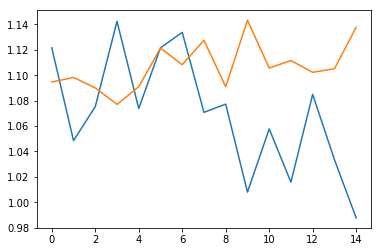

In [13]:
import matplotlib.pyplot as plt

# Loss Plot
plt.plot(training_losses)#, validation_losses)
plt.plot(validation_losses)

plt.show()

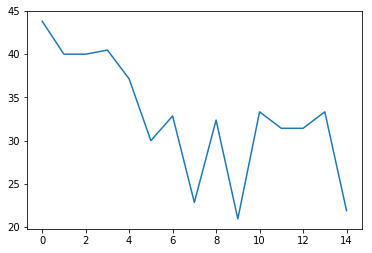

In [14]:
# Accuracy plot
plt.plot(accuracies)
plt.show()